In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

import torch
from torch_geometric import transforms as T
from torch_geometric.utils import to_networkx

path = './datasets'

In [4]:
def show_dataset(dataset, title, split_mask=False, split_idx=False):
    """
    データセットの詳細を表示する関数
    Parameters
    ----------
    dataset     対称のデータセット
    title       データセットの名称。グラフに使用する
    split_mask  訓練/テストのデータ分割をバイナリマスクで行うデータセットの場合
    split_idx   訓練/テストのデータ分割をインデックス指定で行うデータセットの場合

    Returns     なし。データセットの詳細情報が表示され、場合によってはグラフが可視化されて終了する
    -------

    """
    print(f'num data: {len(dataset)}')

    num_classes, num_objective_features = 0, 0
    num_nodes, num_node_attributes, num_edges = [], [], []
    for data in dataset:
        num_edges.append(data.edge_index.shape[-1])     # エッジの個数。

        if data.x is not None or data.pos is not None:  # ノード情報か座標情報が存在する場合
            if data.x is not None:
                x = data.x
            else:
                x = data.pos

            num_nodes.append(x.shape[0])    # ノードの個数
            num_node_attributes.append(x.shape[-1])     # ノードの特徴量の次元

            if data.y.dim() == 1:   # クラスラベルでアノテーションされていると見なす
                if data.y.max() + 1 > num_classes: num_classes = data.y.max() + 1
            else:                   # 連続値で目的変数がアノテーションされていると見なす
                if data.y.shape[-1] > num_objective_features: num_objective_features = data.y.shape[-1]
        else:   # ノード情報も座標情報も存在しない場合
            num_nodes.append(torch.max(data.edge_index).item())
            num_node_attributes.append(0)
            if data.train_y.dim() > 1:
                if data.train_y.shape[-1] > num_classes: num_classes = data.train_y.shape[-1]
            else:
                N = torch.max(torch.cat([data.train_y, data.test_y])).item() + 1
                if N > num_classes: num_classes = N

    if num_classes > 0:
        print(f'num classes: {int(num_classes)}')
    else:
        print(f'num objective features: {int(num_objective_features)}')

    print(f'num nodes: mean {np.mean(num_nodes):.1f} (max {np.max(num_nodes)})')
    print(f'num node attributes: mean {np.mean(num_node_attributes):.1f} (max {np.max(num_node_attributes)})')
    print(f'num edges: mean{np.mean(num_edges):.1f} (max {np.max(num_edges)})')

    print(f'\ngraph sample...')
    data = dataset[0]
    print(f'info: {data}')
    if split_mask:
        print(f'train: {len(data.x[data.train_mask])}/ val: {len(data.x[data.val_mask])}/ test: {len(data.x[data.test_mask])}')
    elif split_idx:
        print(f'train: {len(data.train_idx)}/ test: {len(data.test_idx)}')

    if data.x is not None:
        print('node sample: ')
        print(data.x.numpy())

    if data.pos is not None:
        print('position sample: ')
        print(data.pos.numpy())

    if data.y is not None:
        print('label sample: ')
        print(data.y.numpy())

    N = 4000    # 可視化する際に足切りするノード数。N以上のグラフは重いので可視化しない
    S = 1000    # グラフを可視化する際のノードの最大サイズ

    if data.x is not None and data.x.shape[0] < N:
        plt.figure(figsize=(10, 10))

        nxg = to_networkx(data)     # networkxのグラフに変換する
        pr = nx.pagerank(nxg)       # 可視化のためのページランク計算
        pr_max = np.array(list(pr.values())).max()
        
        draw_pos = nx.spring_layout(nxg, seed=0)    # 可視化する際のノード位置

        cmap = plt.get_cmap('tab10')
        if data.y.shape[0] == data.x.shape[0]:  # ノードごとにアノテーションされている場合
            if data.y.dim() == 1:
                labels = data.y.numpy()
                colors = [cmap(l) for l in labels]

                nx.draw_networkx_nodes(nxg, draw_pos, node_size=[v / pr_max * S for v in pr.values()],
                                       node_color=colors, alpha=0.5)
            else:
                norm = np.linalg.norm(data.y.numpy(), axis=1)
                nx.draw_networkx_nodes(nxg, draw_pos, node_size=[v / pr_max * S for v in pr.values()],
                                       node_color=list(norm), cmap=plt.cm.Reds, alpha=0.5)
        else:   # グラフ全体にアノテーションされている場合
            nx.draw_networkx_nodes(nxg, draw_pos, node_size=[v / pr_max * S for v in pr.values()],
                                   node_color=[cmap(0) for _ in range(len(data.x))], alpha=0.5)

        nx.draw_networkx_edges(nxg, draw_pos, arrowstyle='-', alpha=0.2)

        if data.x.shape[0] < 1000:  # 1000未満ならノード番号も可視化する
            nx.draw_networkx_labels(nxg, draw_pos, font_size=10)

        plt.title(f'{title}: graph')
        plt.show()

    if data.pos is not None and data.pos.shape[0] < N:
        cmap = plt.get_cmap('tab10')
        if data.y is not None and data.y.shape[0] == data.pos.shape[0] and data.y.dim() == 1:
            labels = data.y.numpy()
            colors = [cmap(l) for l in labels]
        else:
            colors = [cmap(0) for _ in range(len(data.pos))]

        if data.pos.shape[1] == 2:      # posが2次元の場合
            plt.figure(figsize=(10, 10))
            plt.scatter(data.pos[:, 0], data.pos[:, 1], alpha=0.5)
        elif data.pos.shape[1] == 3:    # posが3次元の場合
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(projection='3d')
            ax.scatter(data.pos[:, 0], data.pos[:, 1], data.pos[:, 2], alpha=0.2, c=colors)

        plt.title(f'{title}: pos')
        plt.show()

# Karateclub

[torch_geometric.datasets.KarateClub](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub)

["An Information Flow Model for Conflict and Fission in Small Groups"](http://www1.ind.ku.dk/complexLearning/zachary1977.pdf) より

Zacharyの空手クラブネットワークは、154（156では？）のエッジで接続された34のノードを持つ。無向グラフかつ重みなしグラフ。
すべてのノードは、2つのクラスのいずれかにセグメンテーションラベル付けされている。

各ノードは空手クラブの会員を、エッジはクラブ外での会員間の交流を示している。空手クラブは、後にインストラクター（ノード0）とクラブ会長（ノード33）が率いる2つのコミュニティに分裂する。後にインストラクターが率いるコミュニティに属することになる会員にはクラス0が、クラブ会長が率いるコミュニティに属するであろう会員にはクラス1が、割りあてられている。

num data: 1
num classes: 2
num nodes: mean 34.0 (max 34)
num node attributes: mean 34.0 (max 34)
num edges: mean156.0 (max 156)

graph sample...
info: Data(edge_index=[2, 156], x=[34, 34], y=[34])
node sample: 
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
label sample: 
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


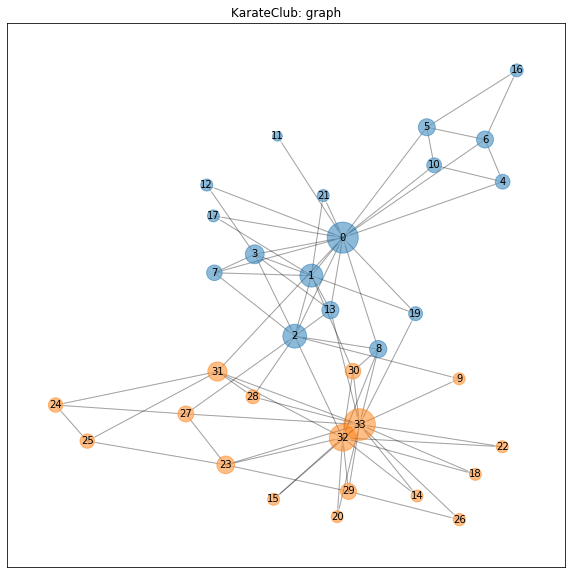

In [6]:
from torch_geometric.datasets import KarateClub

karateclub = KarateClub()
show_dataset(karateclub, 'KarateClub')

# TUDataset

[torch_geometric.datasets.TUDataset](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset)

[TU Dortmund University](https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets) より

TUドルトムント大学が収集した、さまざまなグラフカーネルベンチマークデータセット。
引数nameでロードするデータセットを指定することができる。データセットによってグラフに含まれるノード数が大きく異なるので、TUドルトムント大学のサイトを確認すること。

一部のデータセットにはノードラベルが付いていない。データセットにノード属性が存在する場合、引数use_node_attrを使用してノード属性を読み込むと良い。
あるいは、torch_geometric.transforms.Constantやtorch_geometric.transforms.OneHotDegreeなどを使用してノード属性を追加する

In [7]:
from torch_geometric.datasets import TUDataset

## TUDataset/ OHSU

num data: 79
num classes: 2
num nodes: mean 82.0 (max 171)
num node attributes: mean 190.0 (max 190)
num edges: mean399.3 (max 1646)

graph sample...
info: Data(edge_index=[2, 264], x=[86, 190], y=[1])
node sample: 
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
label sample: 
[1]


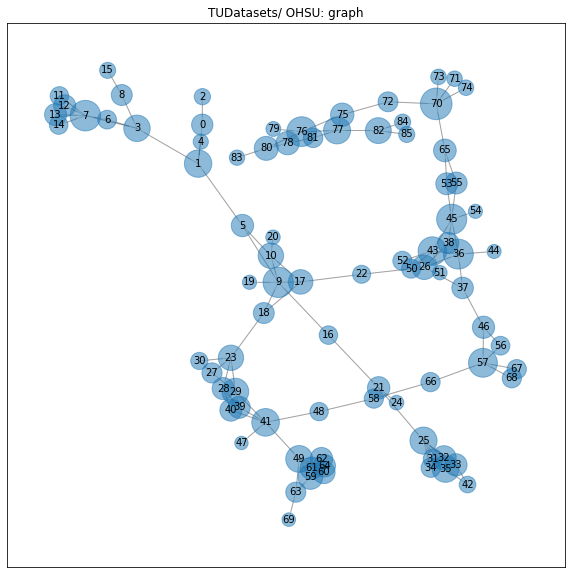

In [8]:
ohsu = TUDataset(os.path.join(path, 'ohsu'), 'OHSU', use_node_attr=True)
show_dataset(ohsu, 'TUDatasets/ OHSU')

## TUDatasets/ MSRC_21

num data: 563
num classes: 20
num nodes: mean 77.5 (max 141)
num node attributes: mean 24.0 (max 24)
num edges: mean396.6 (max 810)

graph sample...
info: Data(edge_index=[2, 434], x=[81, 24], y=[1])
node sample: 
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
label sample: 
[4]


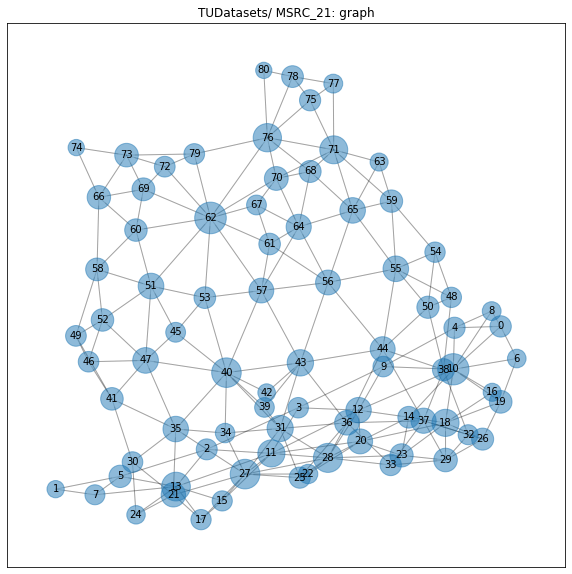

In [9]:
msrc_21 = TUDataset(os.path.join(path, 'msrc_21'), 'MSRC_21', use_node_attr=True)
show_dataset(msrc_21, 'TUDatasets/ MSRC_21')

## TUDatasets/ BZR

num data: 405
num classes: 2
num nodes: mean 35.8 (max 57)
num node attributes: mean 56.0 (max 56)
num edges: mean76.7 (max 120)

graph sample...
info: Data(edge_index=[2, 64], x=[30, 56], y=[1])
node sample: 
[[-2.626347  2.492403  0.061623 ...  0.        0.        0.      ]
 [-2.852647  1.135103  0.232223 ...  0.        0.        0.      ]
 [-1.797347  0.253903  0.431023 ...  0.        0.        0.      ]
 ...
 [ 0.259253 -4.653197 -2.599477 ...  0.        0.        0.      ]
 [ 1.190653 -4.819997 -0.303977 ...  0.        0.        0.      ]
 [ 1.362853 -2.800297  1.117323 ...  0.        0.        0.      ]]
label sample: 
[0]


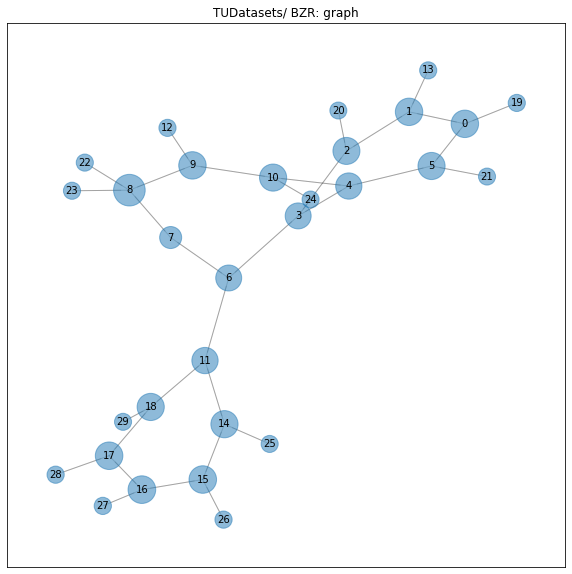

In [10]:
bzr = TUDataset(os.path.join(path, 'bzr'), 'BZR', use_node_attr=True)
show_dataset(bzr, 'TUDatasets/ BZR')

## TUDatasets/ FIRSTMM_DB

num data: 41
num classes: 11
num nodes: mean 1377.3 (max 5037)
num node attributes: mean 6.0 (max 6)
num edges: mean6147.5 (max 21772)

graph sample...
info: Data(edge_attr=[6420, 2], edge_index=[2, 6420], x=[1432, 6], y=[1])
node sample: 
[[0.963589 1.       0.       0.       0.       0.      ]
 [0.940944 1.       0.       0.       0.       0.      ]
 [0.93028  1.       0.       0.       0.       0.      ]
 ...
 [0.856512 0.       0.       1.       0.       0.      ]
 [0.812122 0.       0.       1.       0.       0.      ]
 [0.901283 0.       0.       1.       0.       0.      ]]
label sample: 
[10]


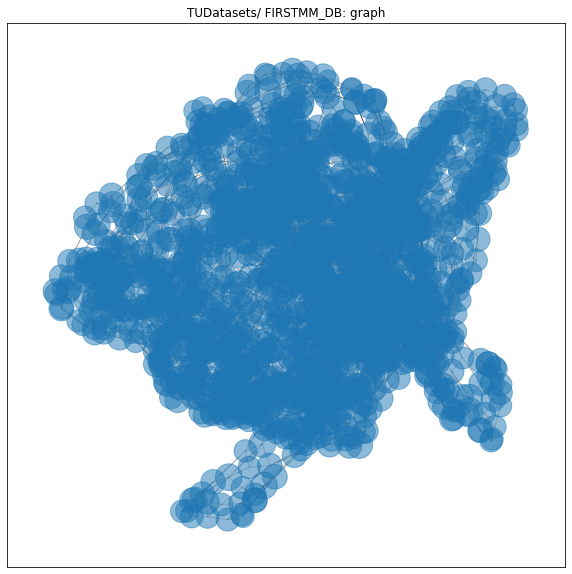

In [11]:
firstmm_db = TUDataset(os.path.join(path, 'firstmm_db'), 'FIRSTMM_DB', use_node_attr=True)
show_dataset(firstmm_db, 'TUDatasets/ FIRSTMM_DB')

# Planetoid

[torch_geometric.datasets.Planetoid](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid)

[Revisiting Semi-Supervised Learning with Graph Embeddings](https://arxiv.org/abs/1603.08861) より

論文の引用に関するデータセットである、「Cora」および「CiteSeer」、「PubMed」。

ノードはドキュメントを表し、エッジは引用を表している。 訓練、検証、テストの分割はバイナリマスクによって行われる。

それぞれのデータセットに含まれるグラフの個数は１つだが、ノード数は約3000〜約20000と大きい。

クラスラベル数3〜7でノードにセグメンテーションラベル付けされている。

In [21]:
from torch_geometric.datasets import Planetoid

## Planetoid/ Cora

num data: 1
num classes: 7
num nodes: mean 2708.0 (max 2708)
num node attributes: mean 1433.0 (max 1433)
num edges: mean10556.0 (max 10556)

graph sample...
info: Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
train: 140/ val: 500/ test: 1000
node sample: 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
label sample: 
[3 4 4 ... 3 3 3]


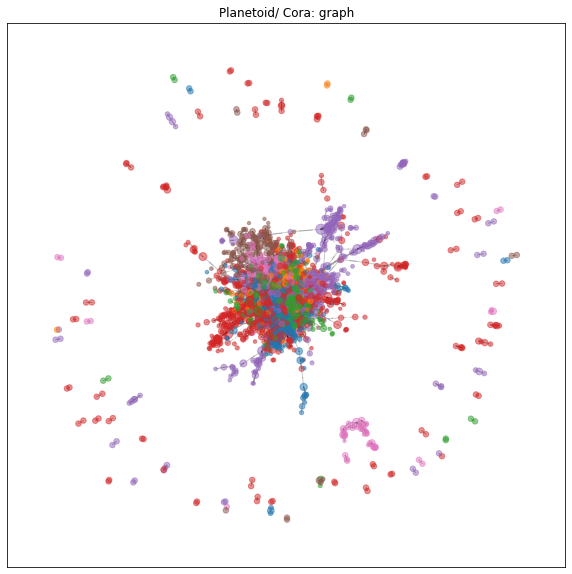

In [22]:
cora = Planetoid(os.path.join(path, 'cora'), 'Cora')
show_dataset(cora, 'Planetoid/ Cora', split_mask=True)

## Planetoid/ CiteSeer

num data: 1
num classes: 6
num nodes: mean 3327.0 (max 3327)
num node attributes: mean 3703.0 (max 3703)
num edges: mean9104.0 (max 9104)

graph sample...
info: Data(edge_index=[2, 9104], test_mask=[3327], train_mask=[3327], val_mask=[3327], x=[3327, 3703], y=[3327])
train: 120/ val: 500/ test: 1000
node sample: 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
label sample: 
[3 1 5 ... 3 1 5]


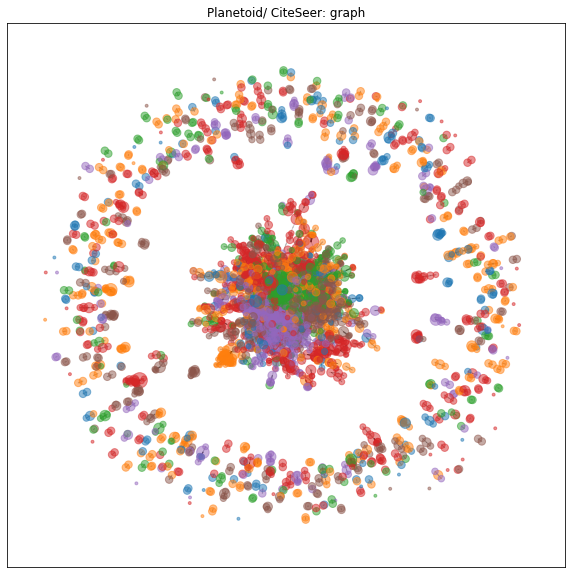

In [23]:
citeseer = Planetoid(os.path.join(path, 'citeseer'), 'CiteSeer')
show_dataset(citeseer, 'Planetoid/ CiteSeer', split_mask=True)

## Planetoid/ PubMed

In [15]:
pubmed = Planetoid(os.path.join(path, 'pubmed'), 'PubMed')
show_dataset(pubmed, 'Planetoid/ PubMed', split_mask=True)

num data: 1
num classes: 3
num nodes: mean 19717.0 (max 19717)
num node attributes: mean 500.0 (max 500)
num edges: mean88648.0 (max 88648)

graph sample...
info: Data(edge_index=[2, 88648], test_mask=[19717], train_mask=[19717], val_mask=[19717], x=[19717, 500], y=[19717])
train: 60/ val: 500/ test: 1000
node sample: 
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.10463634 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.01942665 0.0079607  ... 0.         0.         0.        ]
 [0.10782092 0.         0.         ... 0.         0.         0.        ]
 [0.         0.02658384 0.         ... 0.         0.         0.        ]]
label sample: 
[1 1 0 ... 2 0 2]


# PPI

[torch_geometric.datasets.PPI](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.PPI)

["Predicting Multicellular Function through Multi-layer Tissue Networks"](https://arxiv.org/abs/1707.04638) より

タンパク質間の相互作用ネットワーク。

ノード特徴量は50次元であり、位置遺伝子セット（positional gene sets）、モチーフ遺伝子セット（motif gene sets）、免疫学的特徴（immunological signatures）を含む。

ラベルは121次元の遺伝子オントロジーセット（gene ontology sets）。

データセットの訓練/検証/テストのデータ分割は引数splitで 'train' | 'val' | 'test' で行う。

データセットに含まれるグラフの個数は訓練セットで20個、検証およびテストでそれぞれ2個と多くはないが、ノード数は約2000〜約3000個と少なくない。

In [16]:
from torch_geometric.datasets import PPI

## PPI/train

num data: 20
num objective features: 121
num nodes: mean 2245.3 (max 3480)
num node attributes: mean 50.0 (max 50)
num edges: mean61318.4 (max 106754)

graph sample...
info: Data(edge_index=[2, 32318], x=[1767, 50], y=[1767, 121])
node sample: 
[[-0.08551431 -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 [-0.08551431 -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 [-0.08551431 -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 ...
 [-0.08551431 -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 [-0.08551431 -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 [-0.08551431 -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]]
label sample: 
[[1. 0. 0. ... 1. 1. 0.]
 [1. 0. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


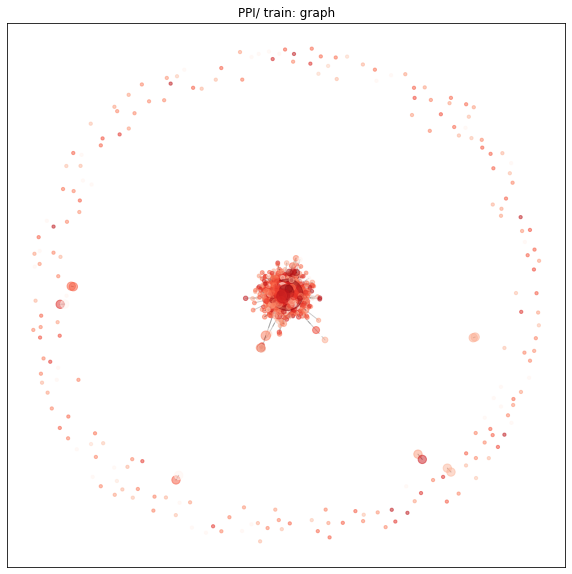

In [17]:
ppi_train = PPI(os.path.join(path, 'ppi'), split='train')
show_dataset(ppi_train, 'PPI/ train')

## PPI/ val

num data: 2
num objective features: 121
num nodes: mean 3257.0 (max 3284)
num node attributes: mean 50.0 (max 50)
num edges: mean99460.0 (max 101474)

graph sample...
info: Data(edge_index=[2, 97446], x=[3230, 50], y=[3230, 121])
node sample: 
[[-0.08551431 -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 [-0.08551431 -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 [-0.08551431 -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 ...
 [-0.08551431 -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 [-0.08551431 -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 [-0.08551431 -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]]
label sample: 
[[1. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


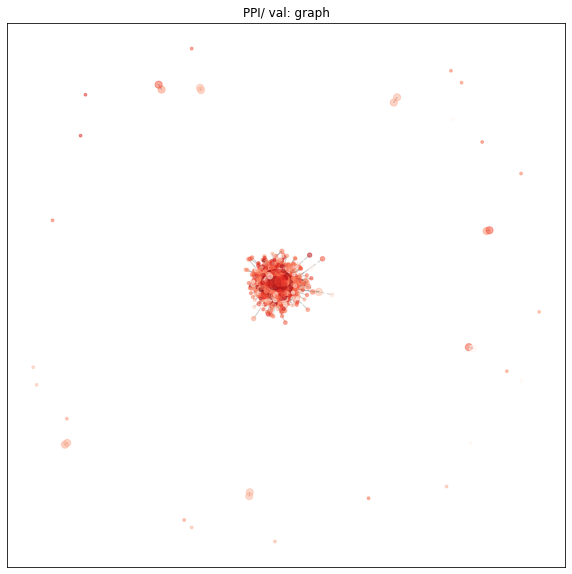

In [18]:
ppi_val = PPI(os.path.join(path, 'ppi'), split='val')
show_dataset(ppi_val, 'PPI/ val')

## PPI/ test

num data: 2
num objective features: 121
num nodes: mean 2762.0 (max 3224)
num node attributes: mean 50.0 (max 50)
num edges: mean80988.0 (max 100648)

graph sample...
info: Data(edge_index=[2, 100648], x=[3224, 50], y=[3224, 121])
node sample: 
[[-0.08551431 -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 [-0.08551431 -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 [-0.08551431 -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 ...
 [-0.08551431 -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 [-0.08551431 -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]
 [-0.08551431 -0.08837446 -0.11277995 ... -0.1398976  -0.14936616
  -0.14811485]]
label sample: 
[[1. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 0.]]


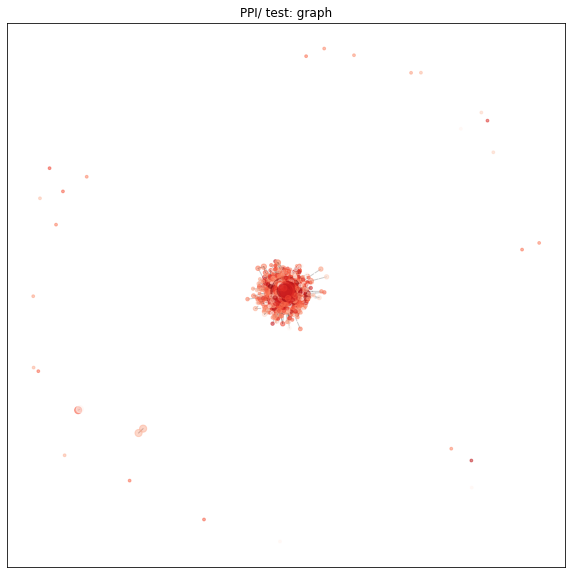

In [19]:
ppi_test = PPI(os.path.join(path, 'ppi'), split='test')
show_dataset(ppi_test, 'PPI/ test')

# QM9

[torch_geometric.datasets.QM9](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.QM9)

["MoleculeNet: A Benchmark for Molecular Machine Learning"](https://arxiv.org/abs/1703.00564) より

約130,000個の、グラフ表現された分子から構成されるデータセット。各グラフは13次元（12次元の誤り？）の連続値が目的変数としてラベル付けされている。

それぞれのグラフは、13次元のノード特徴量と4次元のエッジ特徴量を有している。各グラフには、分子内の原子の単一低エネルギー立体配座に関する完全な空間情報（complete spatial information for the single low energy conformation of the atoms in the molecule）が含まれている。また、 ["Neural Message Passing for Quantum Chemistry"](https://arxiv.org/abs/1704.01212) から原子特徴量を加えている。

データセットに含まれるグラフの個数は約130,000個と巨大だが、その分それぞれのグラフのノード数は数十個以下と小さい。

num data: 133246


num objective features: 12
num nodes: mean 18.3 (max 29)
num node attributes: mean 13.0 (max 13)
num edges: mean37.7 (max 56)

graph sample...
info: Data(edge_attr=[8, 4], edge_index=[2, 8], pos=[5, 3], x=[5, 13], y=[1, 12])
node sample: 
[[0. 1. 0. 0. 0. 6. 0. 0. 0. 0. 0. 1. 4.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
position sample: 
[[-1.2700e-02  1.0858e+00  8.0000e-03]
 [ 2.2000e-03 -6.0000e-03  2.0000e-03]
 [ 1.0117e+00  1.4638e+00  3.0000e-04]
 [-5.4080e-01  1.4475e+00 -8.7660e-01]
 [-5.2380e-01  1.4379e+00  9.0640e-01]]
label sample: 
[[  0.        13.21      -0.3877     0.1171     0.5048    35.3641
    0.044749 -40.47893  -40.476063 -40.475117 -40.498596   6.469   ]]


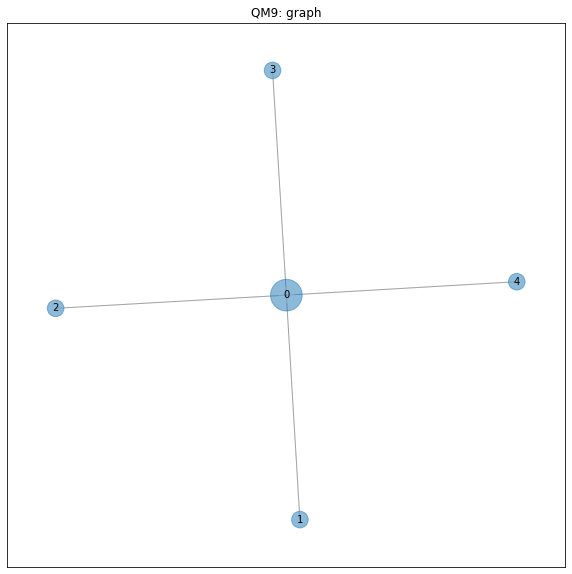

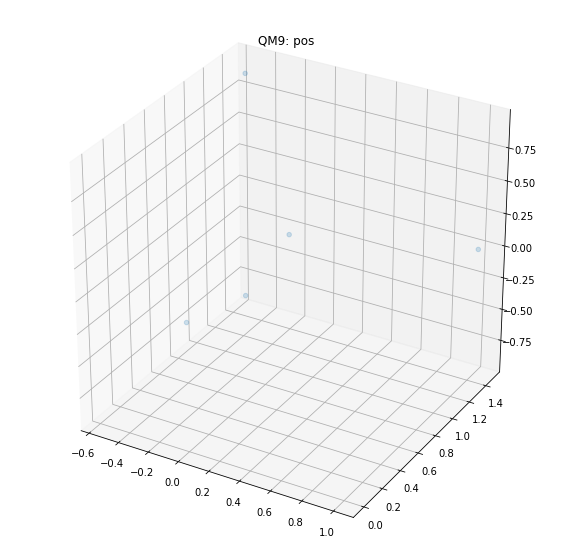

In [20]:
from torch_geometric.datasets import QM9

qm9 = QM9(os.path.join(path, 'qm9'))
show_dataset(qm9, 'QM9')

# Entities

[torch_geometric.datasets.Entities](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Entities)

["Modeling Relational Data with Graph Convolutional Networks"](https://arxiv.org/abs/1703.06103) より

リレーショナルエンティティネットワークである、「AIFB」および「MUTAG」、「BGS」、「AM」のデータセット。

（[実体関連モデル（Entity-relationship Model, ERM）](https://ja.wikipedia.org/wiki/%E5%AE%9F%E4%BD%93%E9%96%A2%E9%80%A3%E3%83%A2%E3%83%87%E3%83%AB)についてのデータか）

訓練/テストのデータ分割は、対応するノードのインデックスが記されたtrain_idx/test_idxによって指定することが出来る。対応するラベルはtrain_y/test_y。

それぞれのデータセットに含まれるグラフは1つだけだが、グラフのノード数は約8000〜約330,000と巨大。

Entitiesデータセットはノード情報（x）はなく、エッジ情報（edge_index）のみがあるため注意する必要がある。

In [24]:
from torch_geometric.datasets import Entities

## Entities/ AIFB

In [25]:
aifb = Entities(os.path.join(path, 'aifb'), name='AIFB')
show_dataset(aifb, 'Entities/ AIFB', split_idx=True)

num data: 1
num classes: 4
num nodes: mean 8284.0 (max 8284)
num node attributes: mean 0.0 (max 0)
num edges: mean58086.0 (max 58086)

graph sample...
info: Data(edge_index=[2, 58086], edge_norm=[58086], edge_type=[58086], test_idx=[36], test_y=[36], train_idx=[140], train_y=[140])
train: 140/ test: 36


## Entities/ MUTAG

In [26]:
mutag = Entities(os.path.join(path, 'mutag'), name='MUTAG')
show_dataset(mutag, 'Entities/ MUTAG', split_idx=True)

num data: 1
num classes: 2
num nodes: mean 23643.0 (max 23643)
num node attributes: mean 0.0 (max 0)
num edges: mean148454.0 (max 148454)

graph sample...
info: Data(edge_index=[2, 148454], edge_norm=[148454], edge_type=[148454], test_idx=[68], test_y=[68], train_idx=[272], train_y=[272])
train: 272/ test: 68


## Entities/ BGS

In [27]:
bgs = Entities(os.path.join(path, 'bgs'), name='BGS')
show_dataset(bgs, 'Entities/ BGS', split_idx=True)

num data: 1
num classes: 2
num nodes: mean 333844.0 (max 333844)
num node attributes: mean 0.0 (max 0)
num edges: mean1832398.0 (max 1832398)

graph sample...
info: Data(edge_index=[2, 1832398], edge_norm=[1832398], edge_type=[1832398], test_idx=[29], test_y=[29], train_idx=[117], train_y=[117])
train: 117/ test: 29


# MNISTSuperpixels

[torch_geometric.datasets.MNISTSuperpixels](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.MNISTSuperpixels)

[Geometric Deep Learning on Graphs and Manifolds Using Mixture Model CNNs](https://arxiv.org/abs/1611.08402) より

MNISTスーパーピクセルデータセット。それぞれのグラフには75のノードと、各ノードの2次元座標が与えられている。
グラフにはMNISTの手書き数字画像に対応した0〜9のラベルが付けられている。

データセットの訓練/テストのデータ分割は引数trainのTrue/Falseで指定する。MNISTと同様に訓練セット60000個、テストセット10000個。

In [28]:
from torch_geometric.datasets import MNISTSuperpixels

## MNISTSuperpixels/ train

num data: 60000


num classes: 10
num nodes: mean 75.0 (max 75)
num node attributes: mean 1.0 (max 1)
num edges: mean1393.3 (max 1690)

graph sample...
info: Data(edge_index=[2, 1399], pos=[75, 2], x=[75, 1], y=[1])
node sample: 
[[0.6004902 ]
 [0.735014  ]
 [0.5124183 ]
 [0.7633987 ]
 [0.5809524 ]
 [0.7941176 ]
 [0.702451  ]
 [0.62352943]
 [0.7882353 ]
 [0.5837535 ]
 [0.5104575 ]
 [0.28104576]
 [0.5781513 ]
 [0.77973855]
 [0.44117647]
 [0.6408964 ]
 [0.28431374]
 [0.78431374]
 [0.69803923]
 [0.53137255]
 [0.845098  ]
 [0.7182073 ]
 [0.29411766]
 [0.60326797]
 [0.8843137 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.

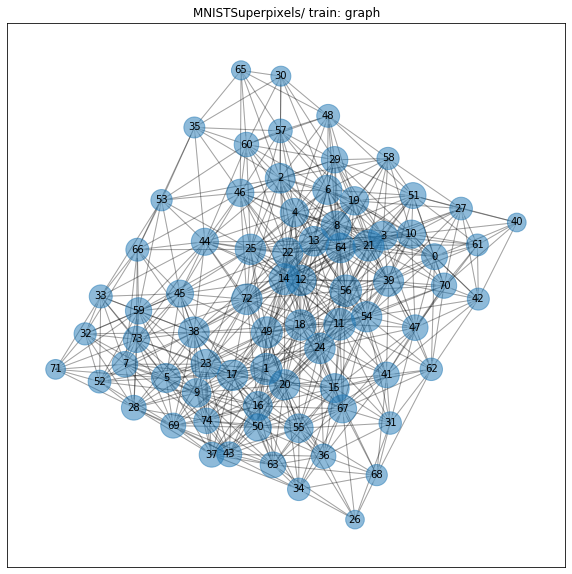

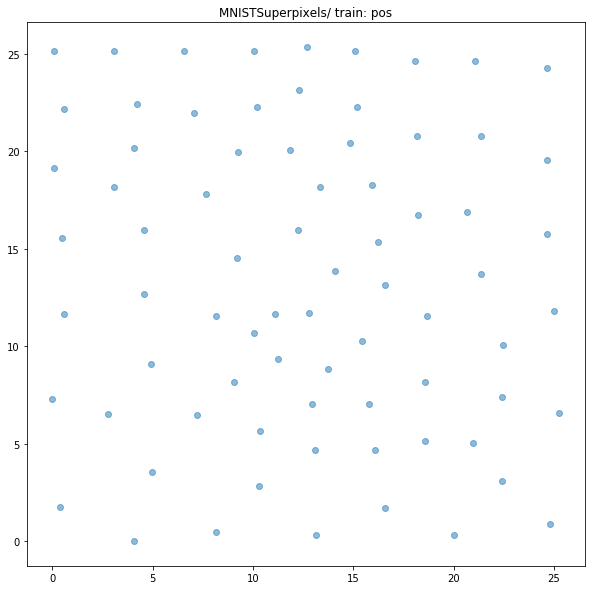

In [29]:
mnistsuperpixels_train = MNISTSuperpixels(os.path.join(path, 'mnistsuperpixels'), train=True)
show_dataset(mnistsuperpixels_train, 'MNISTSuperpixels/ train')

## MNISTSuperpixels/ test

num data: 10000


num classes: 10
num nodes: mean 75.0 (max 75)
num node attributes: mean 1.0 (max 1)
num edges: mean1391.5 (max 1690)

graph sample...
info: Data(edge_index=[2, 1405], pos=[75, 2], x=[75, 1], y=[1])
node sample: 
[[0.9751634 ]
 [0.43823528]
 [0.46568626]
 [0.6384314 ]
 [0.6897059 ]
 [0.595207  ]
 [0.9575163 ]
 [0.6654902 ]
 [0.24901961]
 [0.43529412]
 [0.5838235 ]
 [0.7323529 ]
 [0.972549  ]
 [0.6       ]
 [0.45      ]
 [0.39607844]
 [0.3620915 ]
 [0.2130719 ]
 [0.86732024]
 [0.13137256]
 [0.51215684]
 [0.7104575 ]
 [0.71862745]
 [0.96862745]
 [0.46372548]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.

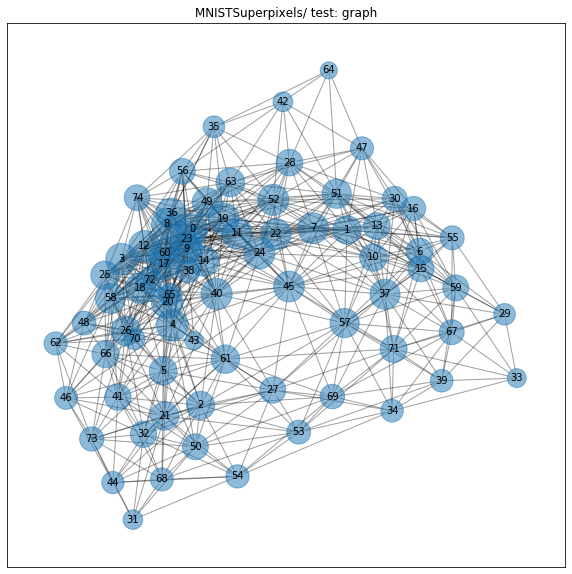

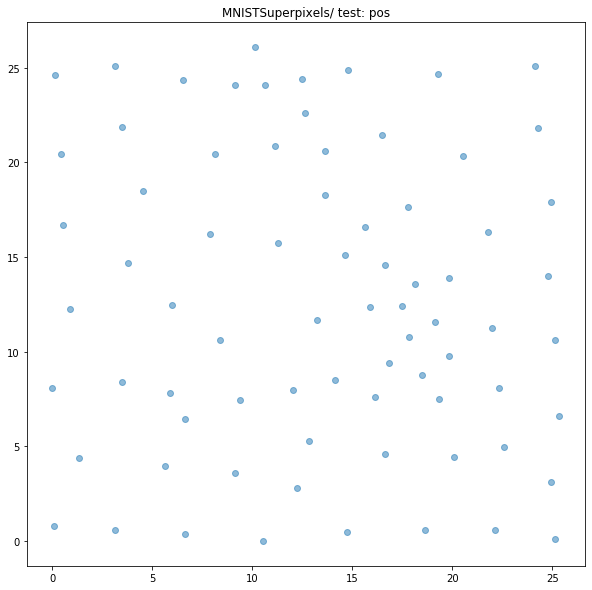

In [30]:
mnistsuperpixels_test = MNISTSuperpixels(os.path.join(path, 'mnistsuperpixels'), train=False)
show_dataset(mnistsuperpixels_test, 'MNISTSuperpixels/ test')

# ShapeNet

[torch_geometric.datasets.ShapeNet](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.ShapeNet)

["A Scalable Active Framework for Region Annotation in 3D Shape Collections"](http://web.stanford.edu/~ericyi/papers/part_annotation_16_small.pdf) より

ShapeNetデータセット。物体のパーツごとにセグメンテーションラベルが付けられている。

16種類の形状カテゴリが存在し、カテゴリによってセグメンテーションのクラス数が2〜6で異なる。形状カテゴリは引数categoriesで指定する。
「'Airplane'」「'Bag'」「'Cap'」「'Car'」「'Chair'」「'Earphone'」「'Guitar'」「'Knife'」「'Lamp'」「'Laptop'」「'Motorbike'」「'Mug'」「'Pistol'」「'Rocket'」「'Skateboard'」「'Table'」

ShapeNetデータセットはポイントクラウド形式で提供される。つまりノード情報やエッジ情報がない代わりに、3次元の座標情報（pos）が存在している。引数transformにtorch_geometric.transforms.KNNGraphやtorch_geometric.transforms.RadiusGraphを指定することでエッジを作成することが可能。ただし「k – The number of neighbors」あるいは「r – The distance」などエッジのハイパーパラメータを指定する必要がある。

データセットの訓練/テストのデータ分割は引数trainでTrue/Falseで指定する。

In [31]:
from torch_geometric.datasets import ShapeNet

## ShapeNet/ Laptop / train (label:2)

num data: 368


num classes: 2
num nodes: mean 2758.5 (max 2845)
num node attributes: mean 3.0 (max 3)
num edges: mean10258.5 (max 10756)

graph sample...
info: Data(edge_index=[2, 10352], pos=[2766, 3], y=[2766])
position sample: 
[[-0.18576 -0.23537 -0.03967]
 [ 0.01168 -0.23537  0.08643]
 [ 0.06972 -0.23537  0.28088]
 ...
 [-0.22521 -0.23862  0.33396]
 [-0.23259 -0.23862 -0.01526]
 [-0.21369 -0.23862  0.23045]]
label sample: 
[0 0 0 ... 0 0 0]


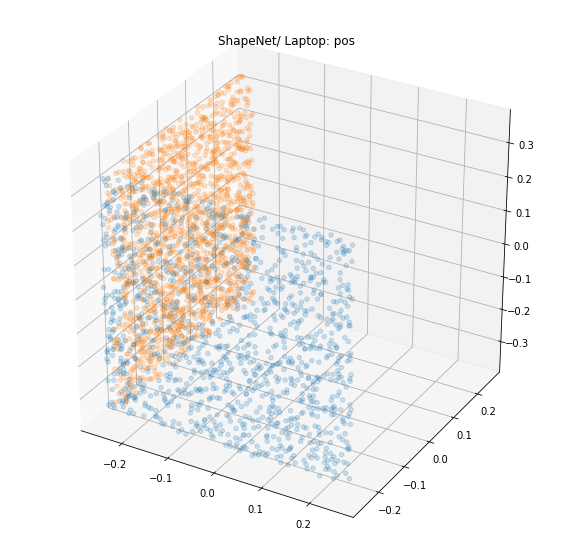

In [32]:
laptop = ShapeNet(os.path.join(path, 'laptop'), categories='Laptop',
                  train=True, transform=T.KNNGraph(k=3, force_undirected=True))
show_dataset(laptop, 'ShapeNet/ Laptop')

## ShapeNet/ Table/ train (label:3)

num data: 4423


num classes: 3
num nodes: mean 2722.5 (max 2974)
num node attributes: mean 3.0 (max 3)
num edges: mean10125.8 (max 11324)

graph sample...
info: Data(edge_index=[2, 10444], pos=[2778, 3], y=[2778])
position sample: 
[[-0.04679  0.20219 -0.29702]
 [-0.21724  0.17195  0.02596]
 [ 0.23645 -0.1595   0.02022]
 ...
 [ 0.10613 -0.21279  0.17906]
 [-0.16304  0.15124 -0.14485]
 [ 0.21223 -0.05629 -0.03186]]
label sample: 
[0 0 1 ... 1 0 1]


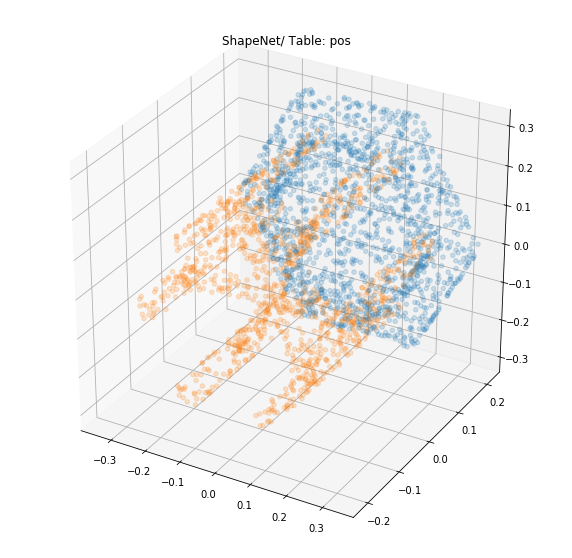

In [33]:
table = ShapeNet(os.path.join(path, 'table'), categories='Table',
                 train=True, transform=T.KNNGraph(k=3, force_undirected=True))
show_dataset(table, 'ShapeNet/ Table')

## ShapeNet/ Chair (label:4)

num data: 3054


num classes: 4
num nodes: mean 2706.1 (max 2927)
num node attributes: mean 3.0 (max 3)
num edges: mean10017.5 (max 11088)

graph sample...
info: Data(edge_index=[2, 10146], pos=[2736, 3], y=[2736])
position sample: 
[[ 0.00422 -0.18397 -0.00562]
 [ 0.06581 -0.18237  0.16265]
 [ 0.17274  0.01673 -0.08843]
 ...
 [-0.04687  0.05257  0.15253]
 [-0.11797  0.07873 -0.11163]
 [-0.11107  0.26449  0.09864]]
label sample: 
[2 2 1 ... 1 0 0]


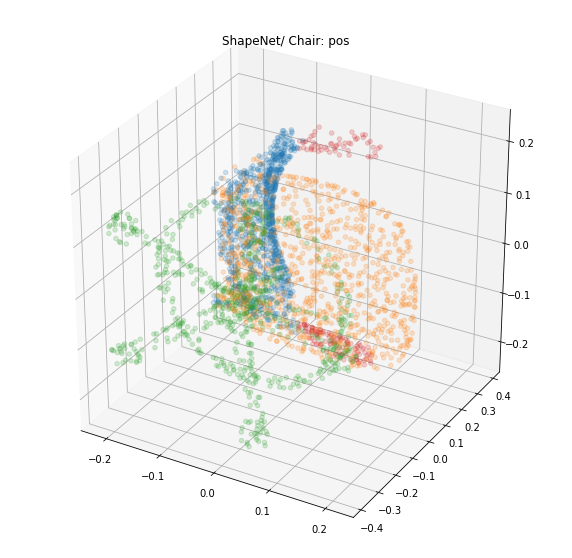

In [34]:
chair = ShapeNet(os.path.join(path, 'chair'), categories='Chair',
                 train=True, transform=T.KNNGraph(k=3, force_undirected=True))
show_dataset(chair, 'ShapeNet/ Chair')

## ShapeNet/ Motorbike/ train (label:6)

num data: 151


num classes: 6
num nodes: mean 2732.1 (max 2910)
num node attributes: mean 3.0 (max 3)
num edges: mean10276.5 (max 11130)

graph sample...
info: Data(edge_index=[2, 10450], pos=[2790, 3], y=[2790])
position sample: 
[[-0.37094  0.01148  0.04014]
 [ 0.03068  0.04941 -0.06343]
 [ 0.3297   0.00568  0.0326 ]
 ...
 [ 0.23285  0.00254  0.04831]
 [ 0.28371 -0.111    0.00739]
 [ 0.36313  0.02609  0.00836]]
label sample: 
[5 0 5 ... 5 2 5]


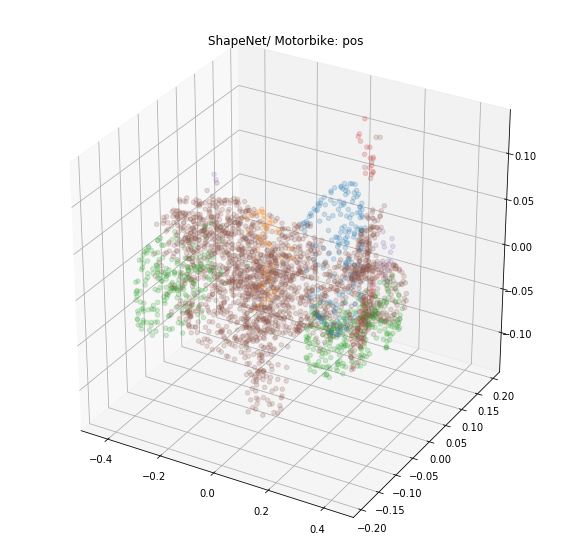

In [35]:
motorbike = ShapeNet(os.path.join(path, 'motorbike'), categories='Motorbike',
                     train=True, transform=T.KNNGraph(k=3, force_undirected=True))
show_dataset(motorbike, 'ShapeNet/ Motorbike')

# ModelNet

[torch_geometric.datasets.ModelNet](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.ModelNet)

[3D ShapeNets: A Deep Representation for Volumetric Shapes](https://people.csail.mit.edu/khosla/papers/cvpr2015_wu.pdf) より

ModelNet10/40データセット。それぞれ10および40カテゴリのCADモデルが含まれている。

ModelNetデータセットはエッジ情報の代わりにメッシュ面を保持している。メッシュをグラフに変換するには、pre_transformにtorch_geometric.transforms.FaceToEdgeを指定する。

また、メッシュをポイントクラウドに変換するには、torch_geometric.transforms.SamplePointsを使用する。各メッシュの面積に応じてメッシュ平面からポイントがサンプリングされる。

ModelNetデータセットもShapeNetデータセットと同じく、ノード情報（x）が存在しないことに注意。

In [36]:
from torch_geometric.datasets import ModelNet

## ModelNet/ 10/ train

num data: 3991


num classes: 10
num nodes: mean 9897.5 (max 502603)
num node attributes: mean 3.0 (max 3)
num edges: mean38819.3 (max 1713006)

graph sample...
info: Data(edge_index=[2, 16596], pos=[3400, 3], y=[1])
position sample: 
[[  6.875    -23.5       -9.5     ]
 [  7.8542   -24.1542    -9.397777]
 [  7.6515   -23.3978    -9.5     ]
 ...
 [  0.858    -18.8794    -9.173748]
 [  0.808    -19.       -10.5     ]
 [  0.808    -19.        -9.173748]]
label sample: 
[0]


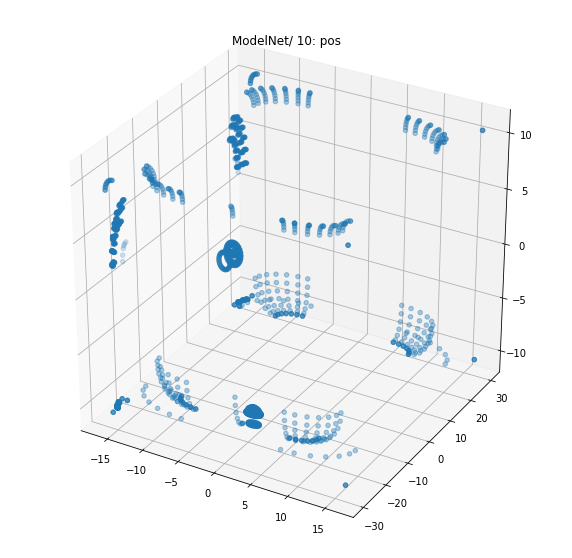

In [37]:
modelnet10 = ModelNet(os.path.join(path, 'modelnet10'), name='10',
                      train=True, pre_transform=T.FaceToEdge())
show_dataset(modelnet10, 'ModelNet/ 10')

## ModelNet/ 40/ train

In [38]:
modelnet40 = ModelNet(os.path.join(path, 'modelnet40'), name='40',
                      train=True, pre_transform=T.FaceToEdge())
show_dataset(modelnet40, 'ModelNet/ 40')

num data: 9843


num classes: 40
num nodes: mean 18097.0 (max 2501688)
num node attributes: mean 3.0 (max 3)
num edges: mean67760.5 (max 14001708)

graph sample...
info: Data(edge_index=[2, 343714], pos=[82364, 3], y=[1])
position sample: 
[[ 371.386  1218.38     89.4456]
 [ 371.386  1218.14    103.225 ]
 [ 371.386  1206.54    103.225 ]
 ...
 [-429.515   889.699   144.7   ]
 [-429.541   889.9     144.576 ]
 [-429.569   890.082   144.427 ]]
label sample: 
[0]
